In [46]:
import pandas as pd
import numpy as np
import os
import wfdb
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import json
from mealpy.evolutionary_based.GA import BaseGA
from mealpy.evolutionary_based import GA
from mealpy import FloatVar
from mealpy import IntegerVar
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import time
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
file_path = Path('C:/Users/vinay/Downloads/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0')

In [3]:
data_files=[]
annot_files=[]
for file in os.listdir(file_path):
    if('.dat' in file):
        data_files.append(file[:-4])
    elif('.atr' in file):
        annot_files.append(file[:-4])

In [4]:
char_to_int = {}
count = 0 

for file in annot_files:
    path_file = os.path.join(file_path, file)
    annotation = wfdb.rdann(path_file, 'atr') 
    
    for symbol in annotation.symbol:
        if symbol not in char_to_int: 
            char_to_int[symbol] = count
            count += 1 

print(char_to_int)

{'+': 0, 'N': 1, 'A': 2, 'V': 3, '~': 4, '|': 5, 'Q': 6, '/': 7, 'f': 8, 'x': 9, 'F': 10, 'j': 11, 'L': 12, 'a': 13, 'J': 14, 'R': 15, '[': 16, '!': 17, ']': 18, 'E': 19, 'S': 20, '"': 21, 'e': 22}


In [5]:
for file in annot_files:
    path_file = os.path.join(file_path, file)
    annotation = wfdb.rdann(path_file, 'atr')
    unique, counts = np.unique(annotation.symbol, return_counts=True)
    print(file, dict(zip(unique, counts)), counts.sum(), len(annotation.sample))

100 {'+': 1, 'A': 33, 'N': 2239, 'V': 1} 2274 2274
101 {'+': 1, 'A': 3, 'N': 1860, 'Q': 2, '|': 4, '~': 4} 1874 1874
102 {'+': 5, '/': 2028, 'N': 99, 'V': 4, 'f': 56} 2192 2192
103 {'+': 1, 'A': 2, 'N': 2082, '~': 6} 2091 2091
104 {'+': 45, '/': 1380, 'N': 163, 'Q': 18, 'V': 2, 'f': 666, '~': 37} 2311 2311
105 {'+': 1, 'N': 2526, 'Q': 5, 'V': 41, '|': 30, '~': 88} 2691 2691
106 {'+': 41, 'N': 1507, 'V': 520, '~': 30} 2098 2098
107 {'+': 1, '/': 2078, 'V': 59, '~': 2} 2140 2140
108 {'+': 1, 'A': 4, 'F': 2, 'N': 1739, 'V': 17, 'j': 1, 'x': 11, '|': 8, '~': 41} 1824 1824
109 {'+': 1, 'F': 2, 'L': 2492, 'V': 38, '~': 2} 2535 2535
111 {'+': 1, 'L': 2123, 'V': 1, '~': 8} 2133 2133
112 {'+': 1, 'A': 2, 'N': 2537, '~': 10} 2550 2550
113 {'+': 1, 'N': 1789, 'a': 6} 1796 1796
114 {'+': 3, 'A': 10, 'F': 4, 'J': 2, 'N': 1820, 'V': 43, '|': 1, '~': 7} 1890 1890
115 {'+': 1, 'N': 1953, '|': 6, '~': 2} 1962 1962
116 {'+': 1, 'A': 1, 'N': 2302, 'V': 109, '~': 8} 2421 2421
117 {'+': 1, 'A': 1, 'N': 153

In [49]:
all_signals = []
all_labels = []

for i in range(48):
    data, field = wfdb.rdsamp(os.path.join(file_path, data_files[i]))
    data = data[:, 0]
    
    annot = wfdb.rdann(os.path.join(file_path, annot_files[i]), 'atr')
    segmented_signals = [data[max(0, peak - 100):min(len(data), peak + 100)] for peak in annot.sample]
    
    segmented_array = np.array([
        np.pad(signal, (0, 200 - len(signal)), mode='edge') if len(signal) < 200 else signal
        for signal in segmented_signals
    ])
    
    labels = annot.symbol[:len(segmented_array)]  

    all_signals.append(segmented_array)
    all_labels.append(labels)

In [50]:
f_X_train, f_X_val, f_X_test = [], [], []
f_y_train, f_y_val, f_y_test = [], [], []

for i in range(48):
    # Reshape signals and flatten labels
    X = np.array(all_signals[i]).reshape(-1, 200)  
    y = np.array(all_labels[i]).flatten()  

    # Count samples per class
    class_counts = Counter(y)

    # Remove stratification if any class has less than 2 samples
    stratify_opt = y if min(class_counts.values()) > 1 else None

    # First split: 85% train+val, 15% test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=stratify_opt
    )

    # Recalculate class counts for train+val set
    class_counts_temp = Counter(y_temp)
    stratify_opt_temp = y_temp if min(class_counts_temp.values()) > 1 else None

    # Second split: 60% train, 25% validation (out of the 85% initial split)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.294, random_state=42, stratify=stratify_opt_temp
    )  # 0.294 ensures 25% of total data

    # Append to final lists
    f_X_train.append(X_train)
    f_X_val.append(X_val)
    f_X_test.append(X_test)
    f_y_train.extend(y_train)
    f_y_val.extend(y_val)
    f_y_test.extend(y_test)

In [51]:
f_X_train = np.vstack(f_X_train)
f_X_val = np.vstack(f_X_val)
f_X_test = np.vstack(f_X_test)

# Ensure 3D shape: (samples, features, 1) for CNN compatibility
f_X_train = np.expand_dims(f_X_train, axis=-1)  # (N, 200, 1)
f_X_val = np.expand_dims(f_X_val, axis=-1)
f_X_test = np.expand_dims(f_X_test, axis=-1)

# Convert labels to NumPy arrays
f_y_train = np.array(f_y_train, dtype=object)
f_y_val = np.array(f_y_val, dtype=object)
f_y_test = np.array(f_y_test, dtype=object)

# Encode string labels as integers
label_encoder = LabelEncoder()
all_labels = np.concatenate([f_y_train, f_y_val, f_y_test])  # Combine all labels for encoding
label_encoder.fit(all_labels)

f_y_train = label_encoder.transform(f_y_train)
f_y_val = label_encoder.transform(f_y_val)
f_y_test = label_encoder.transform(f_y_test)

# Number of unique classes
num_classes = len(label_encoder.classes_)

# One-hot encode the labels for multi-class classification
f_y_train = to_categorical(f_y_train, num_classes=num_classes)
f_y_val = to_categorical(f_y_val, num_classes=num_classes)
f_y_test = to_categorical(f_y_test, num_classes=num_classes)

# Convert to PyTorch tensor (if using PyTorch)
f_X_train = torch.tensor(f_X_train, dtype=torch.float32)
f_X_val = torch.tensor(f_X_val, dtype=torch.float32)
f_X_test = torch.tensor(f_X_test, dtype=torch.float32)

# If sparse, convert to dense before permute
if f_X_train.is_sparse:
    f_X_train = f_X_train.to_dense()
    f_X_val = f_X_val.to_dense()
    f_X_test = f_X_test.to_dense()

# Ensure PyTorch tensor has correct dimensions before permute
if f_X_train.dim() == 2:  # If (N, 200), add a missing dimension
    f_X_train = f_X_train.unsqueeze(-1)  # Shape (N, 200, 1)
    f_X_val = f_X_val.unsqueeze(-1)
    f_X_test = f_X_test.unsqueeze(-1)

# Print final dataset shapes
print(f"Train Shape: {f_X_train.shape}, Validation Shape: {f_X_val.shape}, Test Shape: {f_X_test.shape}")
print(f"Train Labels Shape: {f_y_train.shape}, Validation Labels Shape: {f_y_val.shape}, Test Labels Shape: {f_y_test.shape}")
print(f"Classes: {label_encoder.classes_}")  # Print class mapping

Train Shape: torch.Size([67561, 200, 1]), Validation Shape: torch.Size([28168, 200, 1]), Test Shape: torch.Size([16918, 200, 1])
Train Labels Shape: (67561, 23), Validation Labels Shape: (28168, 23), Test Labels Shape: (16918, 23)
Classes: ['!' '"' '+' '/' 'A' 'E' 'F' 'J' 'L' 'N' 'Q' 'R' 'S' 'V' '[' ']' 'a' 'e'
 'f' 'j' 'x' '|' '~']


In [35]:
# Count occurrences of each class in the training set
train_class_counts = Counter(f_y_train.argmax(axis=1))  # Convert one-hot to class indices
val_class_counts = Counter(f_y_val.argmax(axis=1))
test_class_counts = Counter(f_y_test.argmax(axis=1))

print("Train Class Distribution:", train_class_counts)
print("Validation Class Distribution:", val_class_counts)
print("Test Class Distribution:", test_class_counts)

Train Class Distribution: Counter({9: 44965, 8: 4839, 11: 4358, 13: 4304, 3: 4224, 4: 1521, 2: 776, 18: 588, 6: 484, 22: 378, 0: 283, 1: 267, 19: 142, 20: 123, 16: 87, 21: 71, 5: 63, 7: 51, 10: 21, 17: 8, 14: 4, 15: 3, 12: 1})
Validation Class Distribution: Counter({9: 18779, 8: 2026, 11: 1841, 13: 1781, 3: 1755, 4: 616, 2: 328, 18: 246, 6: 196, 22: 144, 0: 118, 1: 94, 19: 56, 20: 48, 16: 39, 21: 35, 5: 27, 7: 20, 10: 8, 17: 7, 15: 2, 14: 1, 12: 1})
Test Class Distribution: Counter({9: 11308, 8: 1210, 11: 1060, 3: 1049, 13: 1045, 4: 409, 2: 187, 18: 148, 6: 123, 22: 94, 1: 76, 0: 71, 19: 31, 21: 26, 16: 24, 20: 22, 5: 16, 7: 12, 10: 4, 14: 1, 15: 1, 17: 1})


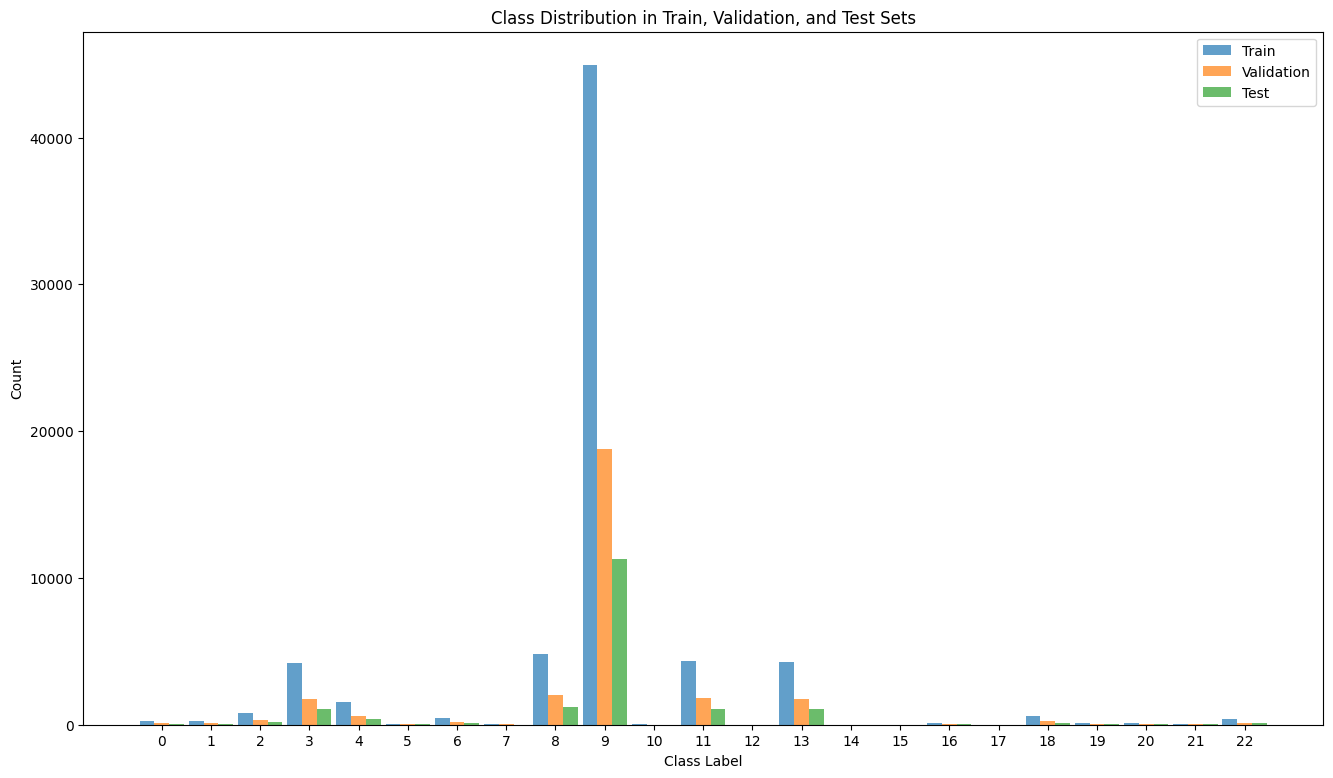

In [36]:
# Get all unique labels across train, val, and test
all_labels = sorted(set(train_class_counts.keys()) | set(val_class_counts.keys()) | set(test_class_counts.keys()))

# Fill missing labels with 0 count
train_counts = [train_class_counts.get(label, 0) for label in all_labels]
val_counts = [val_class_counts.get(label, 0) for label in all_labels]
test_counts = [test_class_counts.get(label, 0) for label in all_labels]

# Create bar chart
plt.figure(figsize=(16, 9))
x = np.arange(len(all_labels))  # Label positions
width = 0.3  # Bar width

plt.bar(x - width, train_counts, width=width, alpha=0.7, label="Train")
plt.bar(x, val_counts, width=width, alpha=0.7, label="Validation")
plt.bar(x + width, test_counts, width=width, alpha=0.7, label="Test")

plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Distribution in Train, Validation, and Test Sets")
plt.xticks(x, all_labels)  # Set x-axis labels
plt.legend()
plt.show()


In [37]:
majority_class = max(train_class_counts.values())
minority_class = min(train_class_counts.values())
imbalance_ratio = majority_class / minority_class
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

Imbalance Ratio: 44965.00


In [31]:
def compute_class_percentage(class_counts):
    total = sum(class_counts.values())
    return {cls: count / total * 100 for cls, count in class_counts.items()}

train_percent = compute_class_percentage(train_class_counts)
val_percent = compute_class_percentage(val_class_counts)
test_percent = compute_class_percentage(test_class_counts)

print("Train Class Percentage:", train_percent)
print("Validation Class Percentage:", val_percent)
print("Test Class Percentage:", test_percent)

Train Class Percentage: {9: 66.55466911383786, 4: 2.251298826245911, 2: 1.14859164310771, 21: 0.10509021476887553, 22: 0.5594943828540134, 10: 0.031083021269667412, 3: 6.252127706813103, 18: 0.8703245955506875, 13: 6.370539216411836, 20: 0.182057696008052, 19: 0.21018042953775107, 6: 0.7163896330723346, 8: 7.1624161868533625, 16: 0.12877251668862214, 7: 0.07548733736919229, 11: 6.450466985390981, 0: 0.41888071520551795, 5: 0.09324906380900223, 14: 0.005920575479936649, 15: 0.004440431609952488, 12: 0.0014801438699841624, 1: 0.3951984132857714, 17: 0.011841150959873299}
Validation Class Percentage: {9: 66.66785004260153, 4: 2.1868787276341948, 13: 6.32277761999432, 22: 0.511218403862539, 3: 6.230474297074695, 18: 0.8733314399318376, 2: 1.1644419199091167, 10: 0.028401022436807723, 21: 0.1242544731610338, 20: 0.17040613462084636, 6: 0.6958250497017893, 8: 7.192558932121557, 16: 0.13845498437943765, 7: 0.0710025560920193, 11: 6.535785288270378, 19: 0.19880715705765406, 5: 0.09585345072422

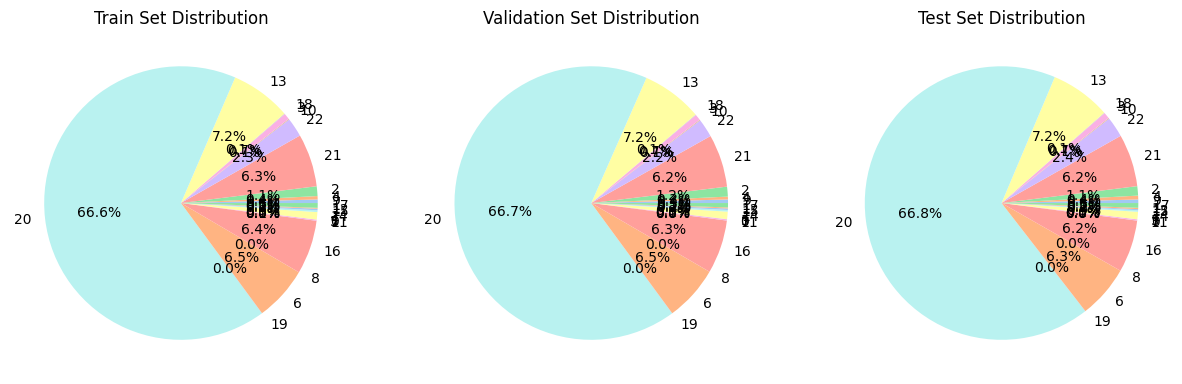

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Pie chart for Train set
axes[0].pie(train_counts, labels=labels, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
axes[0].set_title("Train Set Distribution")

# Pie chart for Validation set
axes[1].pie(val_counts, labels=labels, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
axes[1].set_title("Validation Set Distribution")

# Pie chart for Test set
axes[2].pie(test_counts, labels=labels, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
axes[2].set_title("Test Set Distribution")

plt.show()

In [10]:
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [21]:
class HybridModel(nn.Module):
    def __init__(self, config, num_classes):
        super(HybridModel, self).__init__()

        # Extract hyperparameters from config
        feature_extractor = config[8]  # CNN (0) or RCNN (1)
        sequence_model = config[9]  # BiLSTM (0) or GRU (1)
        num_cnn_layers = int(config[0])
        num_rnn_layers = int(config[1])
        dropout = config[3]
        initial_filters = 2 ** int(config[4])  # Convert to power of 2
        initial_kernel = int(config[5])  # Initial kernel size
        stride = int(config[6])
        initial_hidden_size = 2 ** int(config[10])  # Convert to power of 2

        # 🟢 Convolutional Feature Extractor (CNN Layers)
        self.conv_layers = nn.ModuleList()
        num_filters = initial_filters
        kernel_size = initial_kernel
        in_channels = 1  # ECG has 1 channel

        for _ in range(num_cnn_layers):
            kernel_size = max(2, min(kernel_size, in_channels))  # Ensure kernel size is valid
            stride = min(stride, kernel_size)  # Ensure stride is not larger than kernel
            padding = max(0, (kernel_size - stride) // 2)  # Ensure non-negative padding
            
            self.conv_layers.append(nn.Conv1d(in_channels, num_filters, kernel_size, stride=stride, padding=padding))
            self.conv_layers.append(nn.BatchNorm1d(num_filters))
            self.conv_layers.append(nn.ReLU())
            self.conv_layers.append(nn.Dropout(dropout))

            in_channels = num_filters  # Update for next layer
            num_filters = min(256, num_filters * 2)  # Cap filters at 256
            kernel_size = max(3, kernel_size - 1)  # Decrease kernel size

        # 🟢 Handle RCNN (CNN + 1 LSTM/GRU Layer if enabled)
        self.use_rcnn = feature_extractor == 1
        rnn_input_size = in_channels  # Ensure input size matches CNN output

        if self.use_rcnn:
            self.rnn_layers_rcnn = nn.ModuleList()
            hidden_size = initial_hidden_size

            # RCNN should contain ONLY ONE LSTM/GRU layer
            rnn_layer = (nn.LSTM if sequence_model == 0 else nn.GRU)(
                rnn_input_size, hidden_size, bidirectional=True, batch_first=True
            )
            self.rnn_layers_rcnn.append(rnn_layer)
            self.rnn_layers_rcnn.append(nn.Dropout(dropout))

            # Update input size for the next LSTM/GRU layers
            rnn_input_size = hidden_size * 2  # Account for bidirectional RNN

        # 🟢 Sequence Model (BiLSTM or GRU)
        self.rnn_layers = nn.ModuleList()
        hidden_size = initial_hidden_size

        for _ in range(num_rnn_layers):
            rnn_layer = (nn.LSTM if sequence_model == 0 else nn.GRU)(
                rnn_input_size, hidden_size, bidirectional=True, batch_first=True
            )
            self.rnn_layers.append(rnn_layer)
            self.rnn_layers.append(nn.Dropout(dropout))

            # Update input size for next layers
            rnn_input_size = hidden_size * 2  # Account for bidirectional RNN
            hidden_size = max(16, hidden_size // 2)  # Reduce hidden size

        # 🟢 Fully Connected Layers
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Reduce time dimension to 1
        self.fc = nn.Linear(rnn_input_size, rnn_input_size // 2)  # Use dynamic size
        self.output_layer = nn.Linear(rnn_input_size // 2, num_classes)  # Final layer

        # 🟢 Initialize weights
        self._initialize_weights()

    def forward(self, x):
        # 🟢 CNN Feature Extraction
        for layer in self.conv_layers:
            x = layer(x)

        x = x.permute(0, 2, 1)  # (Batch, TimeSteps, Features)

        # 🟢 Handle RCNN (Reshape CNN output for RNN)
        if self.use_rcnn:            
            for layer in self.rnn_layers_rcnn:
                if isinstance(layer, (nn.LSTM, nn.GRU)):
                    x, _ = layer(x)  # Apply LSTM/GRU
                else:
                    x = layer(x)  # Apply Dropout

        for layer in self.rnn_layers:
            if isinstance(layer, (nn.LSTM, nn.GRU)):
                x, _ = layer(x)  # Get only output
            else:
                x = layer(x)  # Apply Dropout

        # 🟢 Global Pooling & Fully Connected Layers
        x = x.permute(0, 2, 1)  # (Batch, Features, TimeSteps)
        x = self.global_pool(x)  # (Batch, Features, 1)
        x = x.squeeze(-1)  # (Batch, Features)

        x = F.relu(self.fc(x))
        x = self.output_layer(x)

        return x

    def _initialize_weights(self):
        """Initialize weights using Xavier initialization."""
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

In [12]:
def format_filename(config):
    """ Convert model config into a valid filename """
    formatted_config = "_".join([f"{x:.4f}" if isinstance(x, float) else str(x) for x in config])
    formatted_config = re.sub(r'[^\w\-_]', '', formatted_config)  # Remove special characters
    return formatted_config

In [13]:
def measure_latency(model, dataloader, device="cpu"):
    """
    Measures average inference latency (in milliseconds) per sample.
    """
    model.eval()
    total_time = 0.0
    num_samples = 0

    with torch.no_grad():
        for inputs, _ in dataloader:  # We only need inputs, not labels
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]
            
            # Start time measurement
            if device == "cuda":
                torch.cuda.synchronize()  # Ensure GPU operations are finished
                start_time = time.time()
            else:
                start_time = time.perf_counter()

            _ = model(inputs)  # Forward pass

            # End time measurement
            if device == "cuda":
                torch.cuda.synchronize()
                end_time = time.time()
            else:
                end_time = time.perf_counter()

            total_time += (end_time - start_time) * 1000  # Convert to milliseconds
            num_samples += batch_size

    return total_time / num_samples

In [14]:
def convert_to_serializable(obj):
    """ Converts NumPy arrays and other non-serializable objects to lists for JSON serialization """
    if isinstance(obj, np.ndarray):
        return obj.tolist()  # Convert NumPy array to a list
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]  # Recursively process lists
    return obj  # Return normal values unchanged

In [15]:
def log_to_excel(model_name, accuracy, fitness, latency):
    """
    Logs the model's accuracy, fitness, latency, and name into an Excel sheet.
    """
    # Define the Excel file path
    excel_file = "results.xlsx"

    # Create a DataFrame with the new results
    new_result = {
        "Model Name": [model_name],
        "Accuracy": [accuracy],
        "Fitness": [fitness],
        "Latency (ms)": [latency]
    }
    new_df = pd.DataFrame(new_result)

    # Check if the Excel file already exists
    if os.path.exists(excel_file):
        # Load the existing Excel file
        existing_df = pd.read_excel(excel_file)
        # Append the new results to the existing data
        updated_df = pd.concat([existing_df, new_df], ignore_index=True)
    else:
        # Create a new Excel file with the results
        updated_df = new_df

    # Save the updated DataFrame to the Excel file
    updated_df.to_excel(excel_file, index=False)
    print(f"📊 Results logged to {excel_file}")

In [16]:
def train_and_evaluate(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Convert NumPy arrays to PyTorch tensors & reshape
    X_train = f_X_train.clone().detach().float().permute(0, 2, 1)
    X_val = f_X_val.clone().detach().float().permute(0, 2, 1)
    X_test = f_X_test.clone().detach().float().permute(0, 2, 1)

    # Ensure labels are class indices and long dtype
    y_train = torch.tensor(f_y_train, dtype=torch.long).argmax(dim=1)
    y_val = torch.tensor(f_y_val, dtype=torch.long).argmax(dim=1)
    y_test = torch.tensor(f_y_test, dtype=torch.long).argmax(dim=1)

    batch_size = 2**(int(config[7])) if len(config) > 7 else 64
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    num_classes = len(torch.unique(y_train))  # Ensure correct number of classes
    model = HybridModel(config, num_classes).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config[2])

    patience = 4
    best_val_loss = float("inf")
    no_improve_epochs = 0
    best_model_state = None

    num_epochs = 15
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        val_acc = correct / total
        val_loss /= len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {running_loss/len(train_loader):.4f} - Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
            best_model_state = model.state_dict()
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print(f"⚠️ Early stopping at epoch {epoch + 1}")
            break

    # Restore best model state
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Final Test Evaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    latency = measure_latency(model, test_loader, device)
    fitness = test_accuracy - (latency / 100)

    model_name = f"model_{format_filename(config)}.pt"
    torch.save(model.state_dict(), f"models/{model_name}")

    serializable_config = convert_to_serializable(config)
    result = {
        "config": serializable_config,
        "test_accuracy": test_accuracy,
        "latency": latency,
        "fitness": fitness
    }
    with open(f"results/{model_name}.json", "w") as f:
        json.dump(result, f, indent=4)

    print(f"✅ Config: {serializable_config} -> Test Accuracy: {test_accuracy:.4f}, Latency: {latency:.2f}ms, Fitness: {fitness:.4f} | Model Saved: {model_name}")

    log_to_excel(model_name, test_accuracy, fitness, latency)
    return fitness

In [20]:
# Define the search space for the GA
bounds = [
    IntegerVar(lb=1, ub=5),         # 0: Number of CNN layers (Integer)
    IntegerVar(lb=1, ub=5),         # 1: Number of RNN layers (Integer)
    FloatVar(lb=0.0001, ub=0.01),   # 2: Learning rate (Float)
    FloatVar(lb=0.1, ub=0.5),       # 3: Dropout rate (Float)
    IntegerVar(lb=5, ub=8),         # 4: Number of filters in CNN (Integer)
    IntegerVar(lb=3, ub=6),         # 5: Kernel size for CNN (Integer)
    IntegerVar(lb=1, ub=3),         # 6: Stride for CNN (Integer)
    IntegerVar(lb=4, ub=7),         # 7: Batch size (Integer)
    IntegerVar(lb=0, ub=1),         # 8: CNN/RCNN (Integer: 0 = CNN, 1 = RCNN)
    IntegerVar(lb=0, ub=1),         # 9: GRU/BiLSTM (Integer: 0 = BiLSTM, 1 = GRU)
    IntegerVar(lb=6, ub=9),         # 10: Hidden size for RNN (Integer)
]

In [ ]:
# Define problem dictionary for Mealpy
problem_dict = {
    "obj_func": train_and_evaluate,
    "bounds": bounds,
    "minmax": "max"  # We want to maximize the fitness function
}

# Run Genetic Algorithm optimization
print("\nRunning Genetic Algorithm for Model Optimization...\n")
ga_model = GA.BaseGA(epoch=10, pop_size=10, pc=0.9, pm=0.05, selection="roulette")  # 10 generations, 5 models per generation
best_solution = ga_model.solve(problem_dict)

# Extract best architecture and fitness score
best_architecture = best_solution.solution
best_fitness = best_solution.target.fitness

# Save best model details
best_model_info = {
    "best_architecture": best_architecture,
    "best_fitness": best_fitness
}
with open("results/best_model.json", "w") as f:
    json.dump(best_model_info, f, indent=4)

# Print best model
print(f"\n🏆 Best Model Configuration: {best_architecture}, Fitness Score: {best_fitness}")

In [52]:
class ECGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [53]:
batch_size = 32
test_dataset = ECGDataset(f_X_test, f_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Loading
config = [3, 3, 0.0002, 0.4758, 7, 6, 2, 7, 1, 1, 9]
model = HybridModel(config, 23)
model.load_state_dict(torch.load("models/model_30000_30000_00002_04758_70000_60000_20000_70000_10000_10000_90000.pt", weights_only=True))
model.eval()

HybridModel(
  (conv_layers): ModuleList(
    (0): Conv1d(1, 128, kernel_size=(2,), stride=(2,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4758, inplace=False)
    (4): Conv1d(128, 256, kernel_size=(3,), stride=(2,))
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4758, inplace=False)
    (8): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.4758, inplace=False)
  )
  (rnn_layers_rcnn): ModuleList(
    (0): GRU(256, 512, batch_first=True, bidirectional=True)
    (1): Dropout(p=0.4758, inplace=False)
  )
  (rnn_layers): ModuleList(
    (0): GRU(1024, 512, batch_first=True, bidirectional=True)
    (1): Dropout(p=0.4758, inplace=False)
    (2): GRU(1024, 256, batch_first=True, bidirectional=True)
    (

In [55]:
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Ensure inputs have shape (batch_size, channels, sequence_length)
        if inputs.dim() == 2:  # (batch_size, sequence_length)
            inputs = inputs.unsqueeze(1)  # Add channel dimension -> (batch_size, 1, sequence_length)
        elif inputs.shape[1] > inputs.shape[2]:  # Fix incorrect ordering if needed
            inputs = inputs.permute(0, 2, 1)

        # Padding only if sequence length < 3
        if inputs.shape[2] < 3:
            inputs = F.pad(inputs, (0, 3 - inputs.shape[2]))

        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)

        # Ensure labels are in correct format
        labels = labels if labels.dim() == 1 else torch.argmax(labels, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Compute and print metrics
report = classification_report(y_true, y_pred, digits=4)
conf_matrix = confusion_matrix(y_true, y_pred)

print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)


Classification Report:
              precision    recall  f1-score   support

           0     0.8553    0.9155    0.8844        71
           1     0.9868    0.9868    0.9868        76
           2     0.7824    0.9037    0.8387       187
           3     0.9981    0.9914    0.9947      1049
           4     0.9219    0.8655    0.8928       409
           5     0.9412    1.0000    0.9697        16
           6     0.9462    0.7154    0.8148       123
           7     1.0000    0.7500    0.8571        12
           8     0.9926    0.9926    0.9926      1210
           9     0.9905    0.9945    0.9925     11308
          10     0.7500    0.7500    0.7500         4
          11     0.9869    0.9934    0.9901      1060
          13     0.9588    0.9799    0.9692      1045
          14     0.0000    0.0000    0.0000         1
          15     0.0000    0.0000    0.0000         1
          16     0.7692    0.8333    0.8000        24
          17     0.0000    0.0000    0.0000         1
   

C:\Users\vinay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vinay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vinay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

In [58]:
torch.save(model.state_dict(), "best_model.pth")